In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [80]:
df=pd.read_csv('dataset/final.csv', index_col=0)
df.head()

,Wage,International Reputation,Value,Special_Score5,Overall,Club_Overall
0,565.0,5.0,110500.0,2392.0,94,3.0
1,405.0,5.0,77000.0,2417.0,94,3.0
2,290.0,5.0,118500.0,2330.0,92,3.0
4,355.0,4.0,102000.0,2461.0,91,3.0
5,340.0,4.0,93000.0,2324.0,91,3.0


In [83]:
skew_cols = df.skew().sort_values(ascending=False)
skew_cols

Wage                        7.859022
Value                       7.024955
Club_Overall                6.125020
International Reputation    4.050353
Overall                     0.067529
Special_Score5             -0.668218
dtype: float64

In [ ]:
다중공선성 파악하는 방법
VIF = Variance inflation Factors 분산 팽창요인
안전 : vif <5
주의 : 5<vif<10
위험: 10<vif

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['vif factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif['features']=df.columns
vif

,vif factor,features
0,5.742702,Wage
1,17.902691,International Reputation
2,5.131435,Value
3,63.171378,Special_Score5
4,77.176044,Overall
5,3.800936,Club_Overall


In [85]:
df=df[['Wage','Value','Overall','Special_Score5','Club_Overall','International Reputation']]

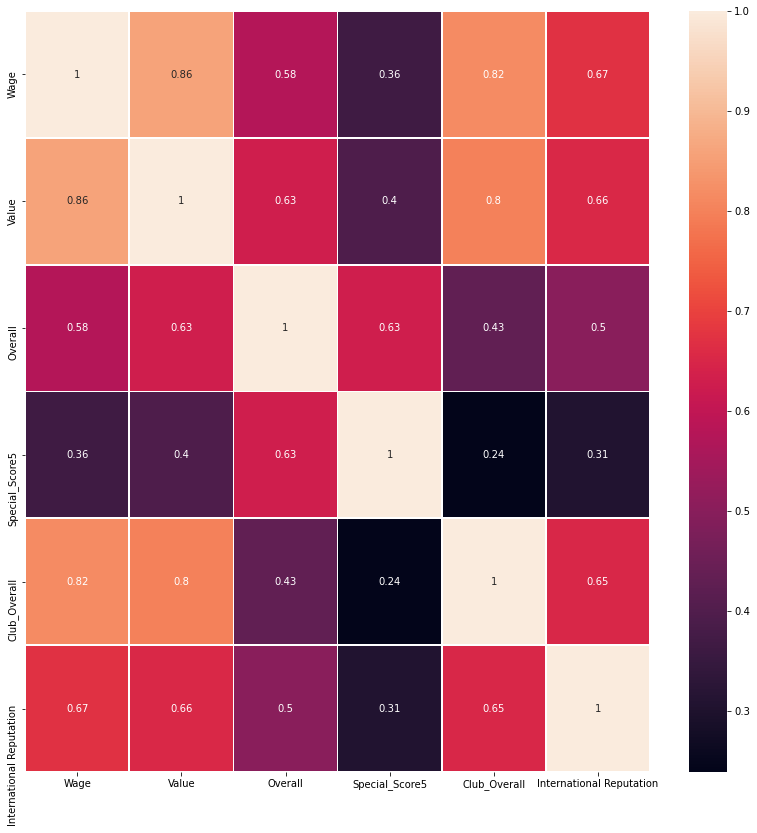

In [86]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(),linewidths=.8, annot=True) 

In [89]:
lm_fifa2=smf.ols('Wage~ Club_Overall+Value+Special_Score5+Overall', data=df).fit()
lm_fifa2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wage   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 1.704e+04
Date:                Mon, 15 Mar 2021   Prob (F-statistic):               0.00
Time:                        05:23:34   Log-Likelihood:                -66864.
No. Observations:               17918   AIC:                         1.337e+05
Df Residuals:                   17913   BIC:                         1.338e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -18.5311      0.916    -20.231      0.000     -20.326     -16.736
Club_Overall      26.6050      0.391     67.975      0.000      25.838      27.372
Value              0.0019   2.63e-05     71.747      0.000       0.002       0.002
Special_Score5     0.0019      0.000      5.563      0.000       0.001       0.003
Overall            0.2847      0.017     17.087      0.000       0.252       0.317
==============================================================================
Omnibus:                    15425.882   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5340403.468
Skew:                           3.235   Prob(JB):                         0.00
Kurtosis:                      87.328   Cond. No.                     7.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
df1=df.copy()

In [40]:
df1['log_W']=np.log1p(df.Wage)
df1['log_V']=np.log1p(df.Value)

In [41]:
df1.drop(['Value', 'Wage'], axis=1, inplace=True)

In [42]:
skew_cols = df1.skew().sort_values(ascending=False)
skew_cols
#  Club_Overall은 원핫인코딩 예정

Club_Overall                6.125020
International Reputation    4.050353
log_W                       1.047452
log_V                       0.318995
Special_Score5             -0.668218
dtype: float64

In [43]:
df1.columns

Index(['International Reputation', 'Special_Score5', 'Club_Overall', 'log_W',
       'log_V'],
      dtype='object')

In [53]:
df1=df1[['log_W','log_V','Special_Score5','Club_Overall','International Reputation']]

In [58]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# df1_scaled=StandardScaler().fit_transform(df1['Special_Score5'])

In [59]:
df1.Club_Overall=df1.Club_Overall.astype('str')
df1['International Reputation']=df1['International Reputation'].astype('str')
df_o=pd.get_dummies(df1)

In [61]:
df_o.columns

Index(['log_W', 'log_V', 'Special_Score5', 'Club_Overall_0.0',
       'Club_Overall_1.0', 'Club_Overall_2.0', 'Club_Overall_3.0',
       'International Reputation_1.0', 'International Reputation_2.0',
       'International Reputation_3.0', 'International Reputation_4.0',
       'International Reputation_5.0'],
      dtype='object')

In [67]:
df_o.to_csv('dataset/df_o_0315.csv')
df_o=pd.read_csv('dataset/df_o_0315.csv', index_col=0)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [76]:
X= df_o.drop(['log_W'],axis = 1)
y= df_o['log_W']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)
# 단순 회귀 분석 모형 생성 및 평가
lr = LinearRegression()
lr.fit(X_train, y_train)
pred= lr.predict(X_test)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,pred) # r_square = lr.score(X_test, y_test)도 같은 값

print('MSE: {0:.3f}, RMSE: {1:.3f}, r2 score: {2:.3f}'.format(mse, rmse,r2))

MSE: 0.296, RMSE: 0.544, r2 score: 0.715
